# Extended Kalman Filter

In [25]:
import sys
import pathlib
import imageio
sys.path.append("..")

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [26]:
from utils.angle import rot_mat_2d

In [20]:
# Covariance for EKF simulation
Q = np.diag([
    0.1,  # variance of location on x-axis
    0.1,  # variance of location on y-axis
    np.deg2rad(1.0),  # variance of yaw angle
    1.0  # variance of velocity
]) ** 2  # predict state covariance
R = np.diag([1.0, 1.0]) ** 2  # Observation x,y position covariance

In [18]:
#  Simulation parameter
INPUT_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([0.5, 0.5]) ** 2

In [4]:
DT = 0.1  # time tick [s]
SIM_TIME = 1.0  # simulation time [s]

In [22]:
show_animation = True

In [7]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v], [yawrate]])
    return u

In [8]:
def observation(xTrue, xd, u):
    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = observation_model(xTrue) + GPS_NOISE @ np.random.randn(2, 1)

    # add noise to input
    ud = u + INPUT_NOISE @ np.random.randn(2, 1)

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

In [9]:
def motion_model(x, u):
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = F @ x + B @ u

    return x

In [11]:
def observation_model(x):
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    z = H @ x

    return z

In [12]:
def jacob_f(x, u):
    """
    Jacobian of Motion Model

    motion model
    x_{t+1} = x_t+v*dt*cos(yaw)
    y_{t+1} = y_t+v*dt*sin(yaw)
    yaw_{t+1} = yaw_t+omega*dt
    v_{t+1} = v{t}
    so
    dx/dyaw = -v*dt*sin(yaw)
    dx/dv = dt*cos(yaw)
    dy/dyaw = v*dt*cos(yaw)
    dy/dv = dt*sin(yaw)
    """
    yaw = x[2, 0]
    v = u[0, 0]
    jF = np.array([
        [1.0, 0.0, -DT * v * math.sin(yaw), DT * math.cos(yaw)],
        [0.0, 1.0, DT * v * math.cos(yaw), DT * math.sin(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

    return jF

In [13]:
def jacob_h():
    # Jacobian of Observation Model
    jH = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    return jH

In [14]:
def ekf_estimation(xEst, PEst, z, u):
    #  Predict
    xPred = motion_model(xEst, u)
    jF = jacob_f(xEst, u)
    PPred = jF @ PEst @ jF.T + Q

    #  Update
    jH = jacob_h()
    zPred = observation_model(xPred)
    y = z - zPred
    S = jH @ PPred @ jH.T + R
    K = PPred @ jH.T @ np.linalg.inv(S)
    xEst = xPred + K @ y
    PEst = (np.eye(len(xEst)) - K @ jH) @ PPred
    return xEst, PEst

In [15]:
def plot_covariance_ellipse(xEst, PEst):  # pragma: no cover
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[1, bigind], eigvec[0, bigind])
    fx = rot_mat_2d(angle) @ (np.array([x, y]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

In [16]:
time = 0.0

# State Vector [x y yaw v]'
xEst = np.zeros((4, 1))
xTrue = np.zeros((4, 1))
PEst = np.eye(4)

xDR = np.zeros((4, 1))  # Dead reckoning

# history
hxEst = xEst
hxTrue = xTrue
hxDR = xTrue
hz = np.zeros((2, 1))

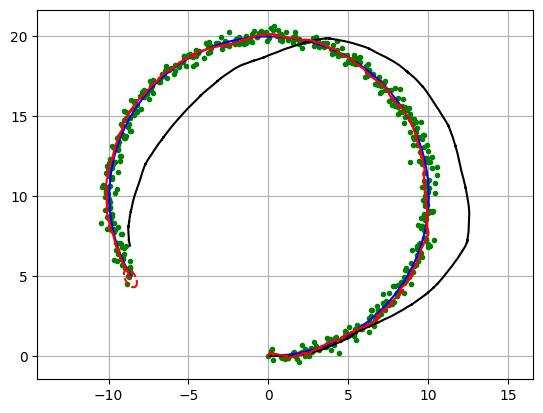

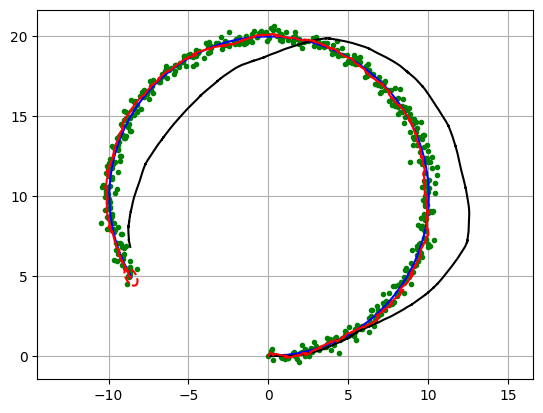

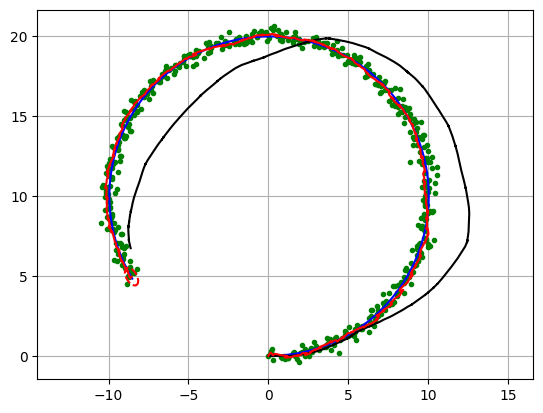

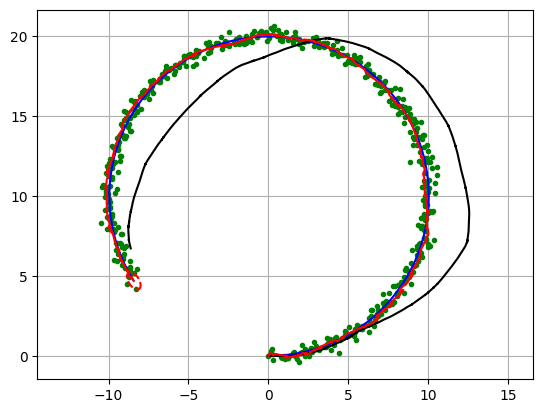

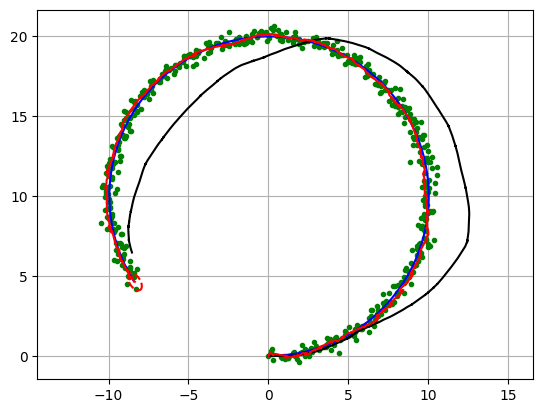

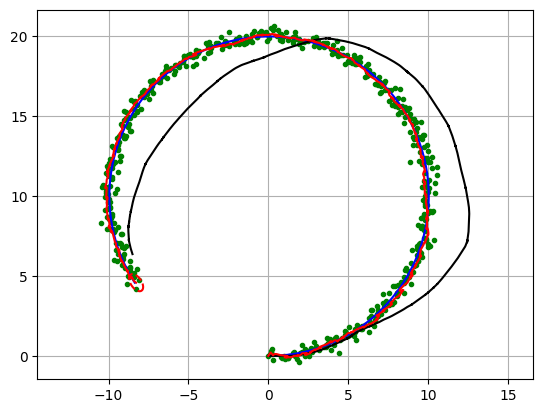

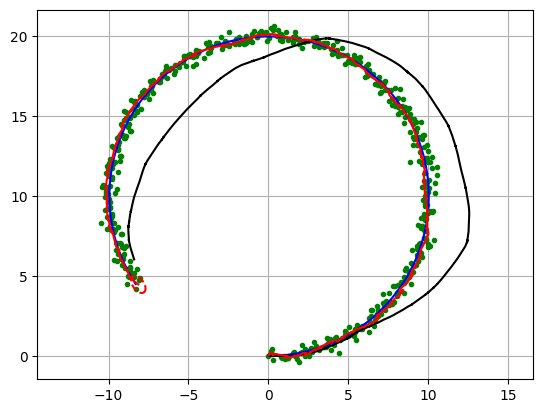

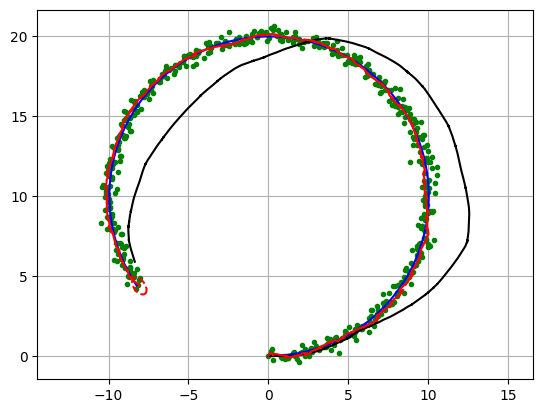

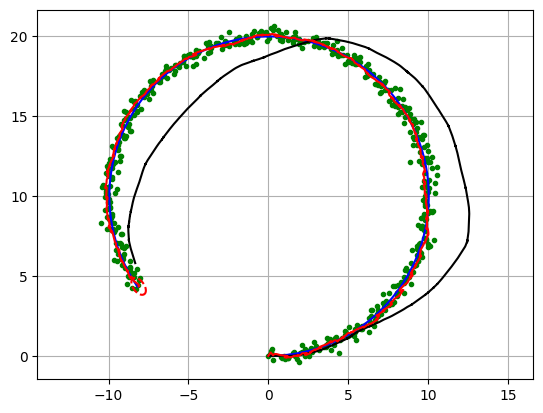

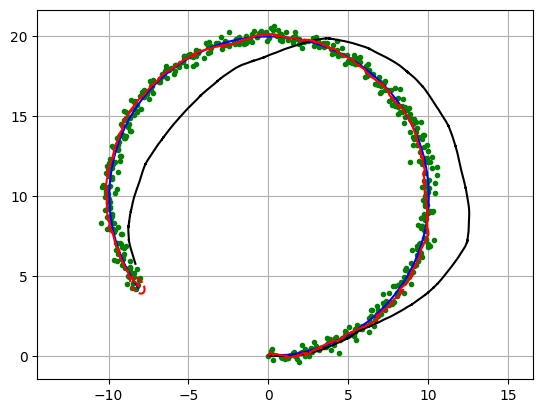

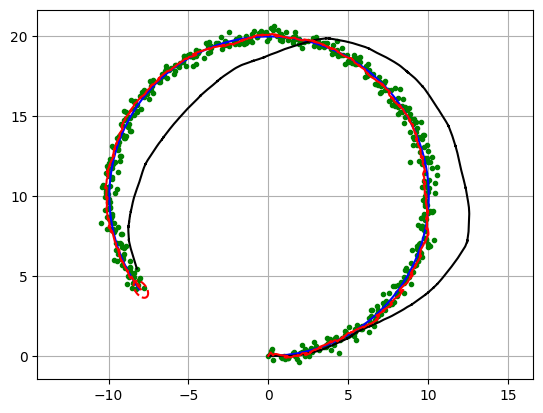

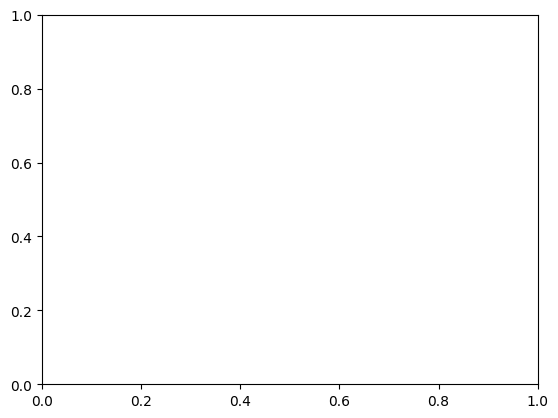

In [39]:
imgs = []
time=0
while SIM_TIME >= time:
    time += DT
    u = calc_input()

    xTrue, z, xDR, ud = observation(xTrue, xDR, u)

    xEst, PEst = ekf_estimation(xEst, PEst, z, ud)

    # store data history
    hxEst = np.hstack((hxEst, xEst))
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    hz = np.hstack((hz, z))

    if show_animation:
        plt.cla()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
        plt.plot(hz[0, :], hz[1, :], ".g")
        plt.plot(hxTrue[0, :].flatten(),
                    hxTrue[1, :].flatten(), "-b")
        plt.plot(hxDR[0, :].flatten(),
                    hxDR[1, :].flatten(), "-k")
        plt.plot(hxEst[0, :].flatten(),
                    hxEst[1, :].flatten(), "-r")
        plot_covariance_ellipse(xEst, PEst)
        plt.axis("equal")
        plt.grid(True)
        # plt.pause(0.001)
        ax = plt.subplots()
        imgs.append(ax)

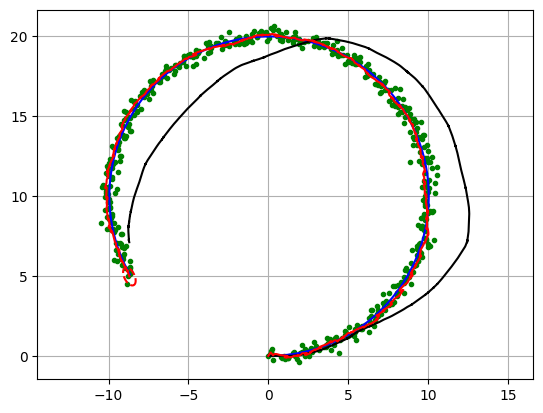

In [38]:
time=0.1
from  matplotlib import animation

fig, ax = plt.subplots()

def animate(i):
    global xTrue, z, xDR, ud, xEst, PEst, hxEst, hxDR, hxTrue, hz, plt, show_animation
    u = calc_input()

    xTrue, z, xDR, ud = observation(xTrue, xDR, u)

    xEst, PEst = ekf_estimation(xEst, PEst, z, ud)

    # store data history
    hxEst = np.hstack((hxEst, xEst))
    hxDR = np.hstack((hxDR, xDR))
    hxTrue = np.hstack((hxTrue, xTrue))
    hz = np.hstack((hz, z))

    if show_animation:
        plt.cla()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
        plt.plot(hz[0, :], hz[1, :], ".g")
        plt.plot(hxTrue[0, :].flatten(),
                    hxTrue[1, :].flatten(), "-b")
        plt.plot(hxDR[0, :].flatten(),
                    hxDR[1, :].flatten(), "-k")
        plt.plot(hxEst[0, :].flatten(),
                    hxEst[1, :].flatten(), "-r")
        plot_covariance_ellipse(xEst, PEst)
        plt.axis("equal")
        plt.grid(True)

loop = int(50/time)
ani = animation.FuncAnimation(fig, animate, frames=loop)

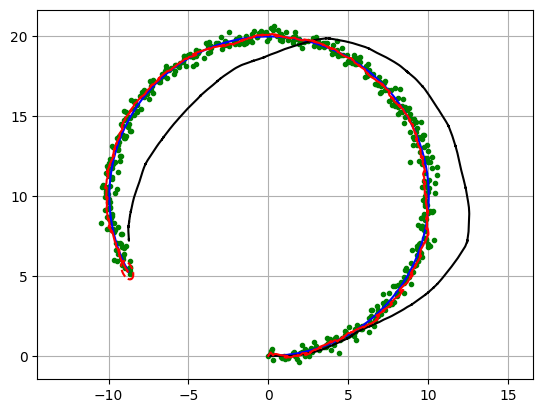

In [36]:
from IPython.display import HTML
HTML(ani.to_html5_video())

In [40]:
import matplotlib.animation as animation
fig = plt.figure()
ani = animation.ArtistAnimation(fig, imgs, interval=50, blit=True,repeat_delay=1000)

<Figure size 640x480 with 0 Axes>

In [41]:
from IPython.display import HTML
HTML(ani.to_html5_video())